# Cell Phenotyping Tutorial

This notebook demonstrates how to perform cell phenotyping using pre-trained KRONOS embeddings. The workflow involves extracting single-cell embeddings from multiplex images and classifying cell phenotypes. Below, we outline the required inputs and provide a step-by-step guide to the process.

## Prerequisites

To follow this tutorial, ensure you have the following data prepared:

1. **Multiplex Images**: TIFF images with multiple markers (e.g., DAPI, CD markers, etc.).
2. **Marker Metadata**: A CSV file containing the following columns:
    - `channel_id`: Identifier for the image channel.
    - `marker_name`: Name of the marker (e.g., DAPI, CD20).
    - `marker_id`: Unique ID for the marker.
    - `marker_mean`: Mean intensity value for normalization.
    - `marker_std`: Standard deviation for normalization.
3. **Cell Masks**: Grayscale images where:
    - Each cell pixel is represented by a unique cell ID.
    - Non-cell pixels are represented by `0`.
4. **Ground Truth Annotations**: A CSV file with the following columns:
    - `image_name`: Name of the multiplex image.
    - `cell_id`: Unique ID of the cell in the cell mask.
    - `x_center`: X-coordinate of the cell center.
    - `y_center`: Y-coordinate of the cell center.
    - `cell_type_id`: Phenotype label of the cell.

**Note**: Refer to the **[How-to-get-marker-metadata-file](https://github.com/mahmoodlab/KRONOS/blob/main/tutorials/1%20-%20How-to-get-marker-metadat-file.ipynb)** tutorial to generate the metadata file for your dataset.

## Overview

This tutorial performs **single-cell-based phenotyping**, which involves the following steps:

1. **Patch Extraction**: Extract cell-centered patches from multiplex images using cell masks.
2. **Feature Extraction**: Use the pre-trained KRONOS model to extract KRONOS embeddings for each cell.
3. **Classification**: Train a logistic regression model to classify cell phenotypes based on the extracted embeddings.
4. **Evaluation**: Evaluate the model using cross-validation and compute metrics such as F1-Score, Balanced Accuracy, and ROC AUC.

By the end of this tutorial, you will have a complete pipeline for single-cell phenotyping using KRONOS embeddings.

## Step 1: Import Required Packages

We begin by importing the necessary libraries and modules for the workflow.

In [1]:
import pandas as pd
from utils import CellPhenotyping 

## Step 2: Experiment Configuration

In this section, we define the configuration and hyperparameters required for the workflow. Ensure your dataset folder in project directory is organized as follows:

### Dataset Structure
- **`dataset/multiplex_images/`**: Contains the multiplex image files (e.g., `.tiff`).
- **`dataset/cell_masks/`**: Contains the cell mask files corresponding to the multiplex images.
- **`dataset/marker_info_with_metadata.csv`**: A CSV file containing marker metadata.
- **`dataset/cell_annotations.csv`**: A CSV file containing ground truth annotations.

### Output Directories
The following directories will be generated in the project directory during the workflow:
- **`patches/`**: Stores the extracted cell-centered patches in `.h5` format.
- **`features/`**: Stores the extracted features in `.npy` format.
- **`folds/`**: Contains cross-validation folds for training, validation, and testing.
- **`results/`**: Stores the results for each fold and aggregated metrics.

In [ ]:
# Define the root directory for the project
project_dir = "/path/to/project/directory/"  # Replace with your actual project directory

# Configuration dictionary containing all parameters for the pipeline
config = {
    # Dataset-related parameters, feel free to modify these paths according to your dataset structure
    "image_dir_path": f"{project_dir}/dataset/multiplex_images/",  # Path to the multiplex image file
    "cell_mask_dir_path": f"{project_dir}/dataset/cell_masks/",  # Path to the cell mask file
    "marker_info_with_metadata_csv_path": f"{project_dir}/dataset/marker_info_with_metadata.csv",  # Path to the marker metadata CSV file
    "gt_csv_path": f"{project_dir}/dataset/cell_annotations.csv",  # Path to the ground truth annotations CSV file
    "num_classes": 16,  # Number of classes for cell phenotyping
    
    # Output directories for intermediate and final results
    "patch_dir": f"{project_dir}/patches/",  # Directory to save extracted patches
    "feature_dir": f"{project_dir}/features/",  # Directory to save extracted features
    "fold_dir": f"{project_dir}/folds/",  # Directory to save cross-validation folds
    "result_dir": f"{project_dir}/results/",  # Directory to save final results
    
    # Model-related parameters
    "checkpoint_path": "hf_hub:MahmoodLab/kronos",  # Path to the pre-trained model checkpoint (local or Hugging Face Hub)
    "hf_auth_token": None,  # Authentication token for Hugging Face Hub (if checkpoint is from the Hub)
    "cache_dir": f"{project_dir}/models/",  # Directory to cache KRONOS model if downloading from Hugging Face Hub
    "model_type": "vits16",  # Type of pre-trained model to use (e.g., vits16)
    "token_overlap": True,  # Whether to use token overlap during feature extraction

    # Patch extraction parameters
    "patch_size": 64,  # Size of the patches to extract (e.g., 64x64 pixels)

    # Feature extraction parameters
    "marker_list": ['DAPI', 'CD11B', 'CD11C', 'CD15', 'CD163', 'CD20', 'CD206', 'CD30', 'CD31', 'CD4', 'CD56', 'CD68', 'CD7', 'CD8', 'CYTOKERATIN', 'FOXP3', 'MCT', 'PODOPLANIN'],  # List of markers to be used for cell phenotyping
    "marker_max_values": 65535.0,  # Maximum possible value marker image, depends on image type (e.g., 255 for uint8, 65535 for uint16)
    "patch_batch_size": 16,  # Batch size for patch-based data loading
    "num_workers": 4,  # Number of workers for data loading

    # Logistic regression parameters
    "max_cells_per_type": 1000,  # Maximum number of cells per type for training, set to None for no limit
    "feature_batch_size": 64,  # Batch size for feature-based data loading
    "n_trials": 25,  # Number of trials for Optuna hyperparameter optimization
    "C_low": 1e-10,  # Lower bound for the regularization parameter (C) in logistic regression
    "C_high": 1e5,  # Upper bound for the regularization parameter (C) in logistic regression
    "max_iter": 10000,  # Maximum number of iterations for logistic regression training
}
obj = CellPhenotyping(config)

## Step 3: Patch Extraction

Extract cell-centered patches from multiplex images using cell masks and annotations. Each patch will be stored in an HDF5 (`.h5`) file with the following structure:

- **Binary Mask**: Stored under the key `mask`, where `1` represents the cell region and `0` represents the background.
- **Marker Datasets**: Each marker dataset contains intensity values corresponding to a specific marker within the patch.

**File Naming Convention**: `{image_name}_{cell_id}.h5`  
Example: `"image_01_000123.h5"` represents cell ID 123 in the image `"image_01.tiff"`.

In [ ]:
obj.patch_extraction()

## Step 4: Feature Extraction

Extract features from cell-centered patches using a pre-trained KRONOS model and saves them for downstream analysis.

In [ ]:
obj.feature_extraction()

## Step 5: Generate Data Folds

Generate data folds for training, validation, and testing. This tutorial uses a cHL dataset, dividing a large visual field into four quadrants. Each quadrant represents one fold.

In [ ]:
obj.folds_generation()

## Step 6: Train Cell Phenotyping Model

Train a logistic regression model on the training data, validate it on the validation data, and evaluate it on the test data. Results for each fold are saved in the output directory.

In [ ]:
obj.train_classification_model()

## Step 7: Evaluate Results

Read the test results for each fold, compute evaluation metrics (F1-Score, Balanced Accuracy, Average Precision, and ROC AUC), and calculate the average and standard deviation across all folds.

In [7]:
obj.eval_classification_model()
obj.calculate_results()
df = pd.read_csv(f"{config['result_dir']}/average_results.csv")
display(df)

,Fold,F1-Score,Balanced Accuracy,Average Precision,ROC AUC
0,fold_1,0.678456,0.725302,0.738385,0.972726
1,fold_2,0.672947,0.732199,0.746246,0.966921
2,fold_3,0.688025,0.748118,0.754187,0.970638
3,fold_4,0.663108,0.726423,0.740870,0.971315
4,Average,0.675634,0.733011,0.744922,0.970400
5,Standard Deviation,0.008070,0.008145,0.005418,0.001919


## Step 8: Visual Results

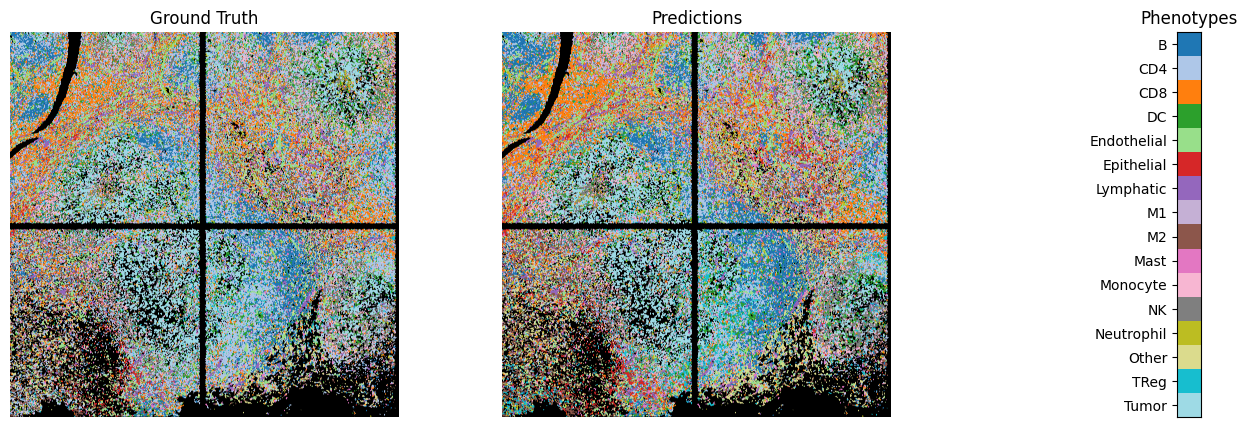

In [8]:
obj.visual_results()